<a name="top"></a>

<div style="width:1000 px">
<div style="float:right; width:300 px"><img src="https://github.com/brianmapes/ATM407/blob/master/images/EnergyMassPlot_spaghettiplot.png?raw=true" alt="(EnergyMassPlot example image here)" style="height: 200px;"></div>

<h1>Static energy profiles: A better view of soundings </h1>

This notebook displays soundings from this Web archive:
http://weather.uwyo.edu/upperair/sounding.html

Described in Mapes, B.E., 2017: *Static energy profiles: a better view of soundings.* Extended abstract for International Workshop on Monsoons IV, 2017, Singapore. Available at the author's Web page, http://www.rsmas.miami.edu/users/bmapes/pagestuff/pubs.html, or download the whole Abstracts Volume:  
https://www.wmo.int/pages/prog/arep/wwrp/new/documents/IWM6AbstractsVolume.pdf

To use the notebook, install Anaconda (a free distribution of Python and Jupyter), and execute <code>pip install metpy </code> and <code>pip install siphon</code>. Then, launch <code> jupyter notebook </code> with this notebook in the directory you launch from.

0. <a href="#DelhiMSEplot">The New Delhi static energy plot</a>

# 0. Important first step to reproduce/ extend this notebook: 
<h3> Visit top link and hit shift-return several times, to define these plotting functions:</h3>

1. <a href="#EnergyMassPlot">define EnergyMassPlot()</a>; then just **hit several shift-returns** to define all of the below functions
1. <a href="#EnergyMassPlotAddCurves">define EnergyMassPlotAddCurves()</a>
1. <a href="#skewTplot">define SkewTplot()</a>
1. <a href="#potential_temps_plot">define potential_temps_plot()</a>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

# 2. Now, select a sounding, and plot it: 
#### After importing necessary modules 

In [5]:
%matplotlib inline 
# makes plots appear inline in the notebook

In [6]:
# import needed modules

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
import metpy.units as mpunits
#from metpy.io import get_upper_air_data
#from siphon import get_upper_air_data      # FUTURE HOME OF THIS FUNCTION

from siphon.simplewebservice.wyoming import WyomingUpperAir

#### Date format is YYYY, M, D, H. 
#### Station codes can be found using the selectors here:  
http://weather.uwyo.edu/upperair/sounding.html

<a name="DelhiMSEplot"></a> 

# An example sounding 

In [177]:
day=3

/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in exp


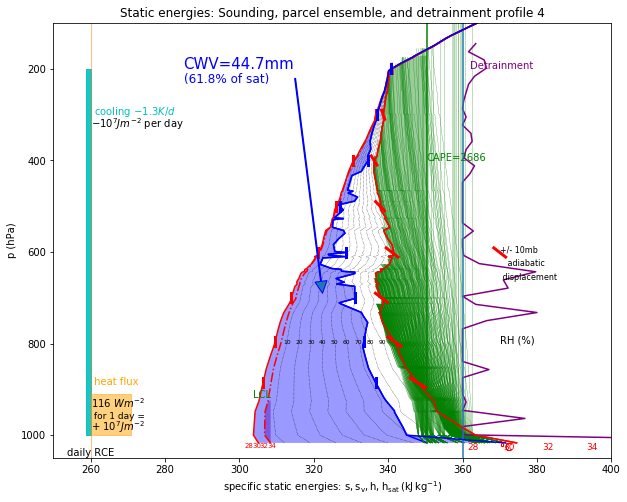

In [178]:
from metpy.units import pandas_dataframe_to_unit_arrays, units

day += 1 
df = WyomingUpperAir.request_data(datetime(2018, 8, day, 0), 'MFL'); data = pandas_dataframe_to_unit_arrays(df)

label = 'Sounding, parcel ensemble, and detrainment profile '+str(day)

# Open the figure and make main sounding plot
fig, ax = plt.subplots(figsize=(10,8))
EnergyMassPlot(data, label)
plt.show()

-------------
# Utilities section (define the plotting functions) 

<hr style="height:2px;">
<a href="#top">Top</a>
<hr style="height:2px;">

<a name="EnergyMassPlot"></a>
<div class="alert alert-info">
     Execute the code cell below to define the EnergyMassPlot() function. 
</div>

In [176]:
def EnergyMassPlot(df, label):
### Plot specific (per unit mass) static energies, as a function of pressure (mass)

    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as units
    from metpy.constants import Cp_d, Rd, Lv, g
    
# new way: df['pressure'].values * units(df.units['pressure'])
    ### GRAB THE DATA
#     p = dataset.variables['pressure'][:]
#     T = dataset.variables['temperature'][:]
#     Td = dataset.variables['dewpoint'][:]
#     Z = dataset.variables['height'][:]
#     u = dataset.variables['u_wind'][:]
#     v = dataset.variables['v_wind'][:]

    p = data['pressure']
    T = data['temperature']
    Td = data['dewpoint']
    Z = data['height']
    u = data['u_wind']
    v = data['v_wind']


    # FIGURE SETUP
    # fig, ax = plt.subplots(figsize=(11,8))

    ### Set up axes  
    ax.axis([250,400, 1050,100])
    right_annot_loc = 370
    
    ### Turn on and locate RCE reference annotations (thermo. energy = area on the diagram)
    RCE_ref = 'true'
    RCEloc = 260 # kJ/kg location on plot


    ### Label axes  
    ax.set_title('Static energies: '+label)
    ax.set_xlabel(
        'specific static energies: $\mathregular{s, s_v, h, h_{sat} \/(kJ\/kg^{-1})}$')
    ax.set_ylabel('p (hPa)')
         
        
    ### The sounding data plot: need mixing ratios from T,Td
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    qs= mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)

    s = g*Z + Cp_d*T 
    sv= g*Z + Cp_d*mpcalc.virtual_temperature(T,q)
    h = s            + Lv*q
    hs= s            + Lv*qs

    ax.plot(s  /1000, p, color='r', linewidth=1.5)  ### /1000 for kJ/kg
    ax.plot(sv /1000, p, color='r', linestyle='-.') 
    ax.plot(h  /1000, p, color='b', linewidth=1.5) 
    ax.plot(hs /1000, p, color='r', linewidth=1.5) 

    ### RH rulings between s and h lines: annotate near 800 hPa level
    annot_level = 800 #hPa
    idx = np.argmin(np.abs(p - annot_level *mpunits.units.hPa))

    for iRH in np.arange(10,100,10):
        ax.plot( (s+ Lv*qs*iRH/100.)/1000, p, linewidth=0.5, linestyle=':', color='k')
        ax.annotate(str(iRH), xy=( (s[idx]+Lv*qs[idx]*iRH/100.)/1000, annot_level),                    
                    horizontalalignment='center',fontsize=6)
    ax.annotate('RH (%)', xy=(right_annot_loc, annot_level), fontsize=10)


### Lifted parcels in green, but only if there is undilute CAPE that is nontrivial (>10 J/kg, say)
# Nontrivial test is used because MetPy CAPE is sometimes some small value just within the PBL or something
# Calculate lifted undilute parcel temperatue profile.
    parcel_Tprofile = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    CAPE,CIN = mpcalc.cape_cin(p,T,Td,parcel_Tprofile)
    ELp,ELT = mpcalc.el(p,T,Td)
    ELindex = np.argmin(np.abs(p - ELp))
    
    ELps = [ELp.magnitude] # Initialize an array of EL pressures for detrainment profile


    # print(CAPE,CIN)

    if ~np.isnan(CAPE.magnitude):
        if CAPE.magnitude >10:  
            parcelh  = h [0]        # for a layer mean: np.mean(h[idx1:idx2])
            parcelsv = sv[0]
            parcelp0 = p[0]

            # Plot LCL at saturation point, above the lifted sv of the surface parcel 
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
            ax.annotate('LCL', xy=(sv[0]/1000., lcl_pressure), fontsize=10, color='g', horizontalalignment='right')
            # Purple fill for negative buoyancy below LCL:
            ax.fill_betweenx(p, sv/1000., parcelsv/1000., where=p>lcl_pressure, facecolor='purple', alpha=0.4)

            # Positive moist convective buoyancy in green 
            # Above LCL:
            ax.fill_betweenx(p, hs/1000., parcelh/1000., where= parcelh>hs, facecolor='g', alpha=0.4)

            

#
#
#
#
#
#
#
#
#
            
# Depict Entraining parcels
            # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
            # M=1 at ground without loss of generality
            

            
# Distribution of surface parcel h offsets
            H0STDEV = 2000 # J/kg
            h0offsets = np.random.normal(0,H0STDEV,20)*mpunits.units('meter ** 2 / second ** 2')    
# Distribution of entrainment rates 
            entrainment_rates = np.arange(0,2,0.05) /(mpunits.units('km'))

        
        
            for h0offset in h0offsets: 
                h4ent = h; h4ent[0] += h0offset
                #print(h0offset)        
                
                for eps in entrainment_rates: 
                    #print('eps: ', eps)
                    M = np.exp(eps * (Z-Z[0]).to('m')).to('dimensionless')

                    # dM is the mass contribution at each level, with 1 at the origin level. 
                    M[0] = 0
                    dM = np.gradient(M)

                    # parcel mass is a  sum of all the dM's at each level
                    # conserved linearly-mixed variables like h are weighted averages 
                    hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
    #
            # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                    posboy  = (hent > hs); posboy[0] = True  # so there is always a detrainment level
                    ELindex_ent = np.max(np.where(posboy))
            # Plot the curve        
                    ax.plot( hent[0:ELindex_ent+2]/1000., p[0:ELindex_ent+2], linewidth=0.25, color='g')
            # Keep a list for a histogram plot (detrainment profile) 
                    ELps.append( p[ELindex_ent].magnitude )


            
# Plot a crude histogram of parcel detrainment levels
            NBINS =50
            hist, pbins = np.histogram(ELps[:], bins=NBINS)
            norm = 20/max(hist[0:NBINS-2]) # scale the plot to 20 kJ/kg for the eye 
            
            ax.plot( 360+hist[:]*norm, pbins[1:], color='purple')
            ax.plot( [360,360], [1100,0])
            ax.annotate('Detrainment', xy=(362, 200), color='purple')
        
    
# Overplots on the mess: undilute parcel and CAPE, etc. 
            ax.plot( (1,1)*parcelh/1000., (1,0)*parcelp0, color='g')
            maxbindex = np.argmax(parcel_Tprofile - T)
            ax.annotate('CAPE='+str(int(CAPE.magnitude)), 
                        xy=(parcelh/1000., p[maxbindex]), color='g')

            # Replot the sounding on top of all that mess
            ax.plot(hs /1000, p, color='r', linewidth=1.5) 
            ax.plot(h  /1000, p, color='b', linewidth=1.5) 

#
#
#
#
#
#
#
#
#


                

    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*mpunits.units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*mpunits.units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dp: hydrostatic
        rho = (p[idx]/Rd/T[idx])
        dZ = -dp/rho/g
        #dp = -rho*g*dZ

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dhsat
        #qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T)     ,p)
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) -qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (hs[idx]+dhs*(-1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (s [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (h [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 600*ilev.units:
            ax.plot(right_annot_loc*hs.units +dhs*(-1,1)/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('+/- 10mb', xy=(right_annot_loc,600), fontsize=8)
            ax.annotate('   adiabatic', xy=(right_annot_loc,630), fontsize=8)
            ax.annotate(' displacement', xy=(right_annot_loc,660), fontsize=8)


    ### Blue fill proportional to precipitable water, and blue annotation
    ax.fill_betweenx(p, s/1000., h/1000., where=h > s, facecolor='b', alpha=0.4)

    # Have to specify the top of the PW integral. 
    # I want whole atmosphere of course, but 200 hPa captures it all really. 
    import metpy.calc as mpcalc
    p_PWtop = max(200*mpunits.units.mbar, min(p) +1*mpunits.units.mbar)
    PW = mpcalc.precipitable_water(Td,p, top=p_PWtop)
    PWs = mpcalc.precipitable_water(T,p, top=p_PWtop)
    CRH = (PW/PWs).magnitude *100. 

    # PW annotation arrow tip at 700 mb
    idx = np.argmin(np.abs(p - 700*p.units))
    centerblue = (s[idx]+h[idx])/2.0 /1000.

    ax.annotate('CWV='+str(round(PW.to('mm').magnitude, 1))+'mm',
                xy=(centerblue, 700), xytext=(285, 200), 
                color='blue', fontsize=15,
                arrowprops=dict(width = 1, edgecolor='blue', shrink=0.02),
                )
    ax.annotate('(' + str(round(CRH,1)) +'% of sat)',
                xy=(285, 230), color='blue', fontsize=12)



    ### Surface water values at 1C intervals, for eyeballing surface fluxes
    sT = np.trunc(T[0].to('degC'))
    sTint = int(sT.magnitude)

    for idT in [-2,0,2,4]:
        ssTint = sTint + idT # UNITLESS degC integers, for labels

        # Kelvin values for computations
        ssTC = ssTint *mpunits.units('degC')
        ssTK = ssTC.to('kelvin')
        ss = g*Z[0] + Cp_d*ssTK 
        hs = ss     + Lv*mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(ssTK) ,p[0])

        ax.annotate(str(ssTint), xy=(ss/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=7)
        ax.annotate(str(ssTint), xy=(hs/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=9)
        ax.annotate('\u00b0C ', xy=(right_annot_loc, p[0]), verticalalignment='top', 
                    fontsize=10, color='r')
        
        
### Some non-data-dependent standard annotations
    if(RCE_ref):
        ### Energy is area, draw reference boxes. 
        ax.plot    ([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
        ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')


        #### Radiative cooling reference
        ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
                [1000 , 1000    , 200     , 200, 1000],             
                linewidth=1, color='c', alpha=0.9)

        ax.annotate(' cooling $-1.3 K/d$',  xy=(RCEloc, 300), color='c')
        ax.annotate('$- 10^7 J m^{-2}$ per day', xy=(RCEloc, 330))

        #### Surface flux reference
        ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
                [1000 , 1000   , 910    , 910, 1000],             
                linewidth=1, color='orange', alpha=0.5)

        ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
        ax.annotate('116 $W m^{-2}$', xy=(RCEloc,940))
        ax.annotate(' for 1 day ='     , xy=(RCEloc,965), fontsize=9)
        ax.annotate('+ $10^7 J m^{-2}$'  , xy=(RCEloc, 990))


<hr style="height:2px;">
<a href="#top">Top</a>
<hr style="height:2px;">

<a name="EnergyMassPlotAddCurves"></a> 
<div class="alert alert-info">
     Execute the code cell below to define the EnergyMassPlotAddCurves() function. 
</div>

In [2]:
def EnergyMassAddCurves(dataset, linewidth):
### Overplot additional data curves of static energies as a function of pressure

    ### GRAB THE DATA
#     p = dataset.variables['pressure'][:]
#     T = dataset.variables['temperature'][:]
#     Td = dataset.variables['dewpoint'][:]
#     Z = dataset.variables['height'][:]
#     u = dataset.variables['u_wind'][:]
#     v = dataset.variables['v_wind'][:]

    p = data['pressure']
    T = data['temperature']
    Td = data['dewpoint']
    Z = data['height']
    u = data['u_wind']
    v = data['v_wind']


    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as mpunits
    from metpy.constants import Cp_d, Rd, Lv, g

    ### Set up axes  
    ax.axis([250,400, 1050,100])
        
    ### The sounding data plot: need mixing ratios from T,Td
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    qs= mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)

    s = g*Z + Cp_d*T 
    sv= g*Z + Cp_d*mpcalc.virtual_temperature(T,q)
    h = s            + Lv*q
    hs= s            + Lv*qs

    ax.plot(s  /1000, p, color='r', linewidth=linewidth)  ### /1000 for kJ/kg
    ax.plot(sv /1000, p, color='r', linewidth=linewidth, linestyle='-.') 
    ax.plot(h  /1000, p, color='b', linewidth=linewidth) 
    ax.plot(hs /1000, p, color='r', linewidth=linewidth) 

<a name="skewTplot"></a> 
<div class="alert alert-info">
     Execute the code cell below to define the skewTplot() function. 
</div>

<hr style="height:2px;">
<a href="#top">Top</a>
<hr style="height:2px;">

In [3]:
def skewTplot(dataset, label):
### Plot specific (per unit mass) static energies, as a function of pressure (mass)

    ### GRAB THE DATA
#     p = dataset.variables['pressure'][:]
#     T = dataset.variables['temperature'][:]
#     Td = dataset.variables['dewpoint'][:]
#     Z = dataset.variables['height'][:]
#     u = dataset.variables['u_wind'][:]
#     v = dataset.variables['v_wind'][:]

    p = data['pressure']
    T = data['temperature']
    Td = data['dewpoint']
    Z = data['height']
    u = data['u_wind']
    v = data['v_wind']


    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as mpunits
    from metpy.constants import Cp_d, Rd, Lv, g
    from metpy.plots import Hodograph, SkewT
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # FIGURE SETUP
    # fig, ax = plt.subplots(figsize=(11,8))

    # Calculate the LCL
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    # print(lcl_pressure, lcl_temperature)

    # Calculate the parcel temperatue profile.
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

    # Create a new figure. The dimensions here give a good aspect ratio
    # fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p, u, v)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)

    # Plot LCL as black dot
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Plot the parcel profile as a black line
    skew.plot(p, parcel_prof, 'k', linewidth=2)

    # Color regions of CAPE and CIN (the area between the actual temperature and
    # the parcel path).
    skew.ax.fill_betweenx(p, T, parcel_prof, where=T >= parcel_prof, facecolor='blue', alpha=0.4)
    skew.ax.fill_betweenx(p, T, parcel_prof, where=T < parcel_prof, facecolor='red', alpha=0.4)

    # Plot a zero degree isotherm
    l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    # Create a hodograph
    # Create an inset axes object that is 40% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=80.)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, np.hypot(u, v))  # Plot a line colored by wind speed

    # Show the plot
    plt.show()

<hr style="height:2px;">
<a href="#top">Top</a>
<hr style="height:2px;">

<a name="potential_temps_plot"></a> 
<div class="alert alert-info">
     Execute the code cell below to define the potential_temps_plot() function. 
</div>

In [4]:
def potential_temps_plot(dataset, label): 
    
    ### GRAB THE DATA
#     p = dataset.variables['pressure'][:]
#     T = dataset.variables['temperature'][:]
#     Td = dataset.variables['dewpoint'][:]
#     Z = dataset.variables['height'][:]
#     u = dataset.variables['u_wind'][:]
#     v = dataset.variables['v_wind'][:]

    p = data['pressure']
    T = data['temperature']
    Td = data['dewpoint']
    Z = data['height']
    u = data['u_wind']
    v = data['v_wind']

    
    ### Plot equivalent temperatures
    ### Set up axes and ranges 
    ax.set_xlabel('$\mathregular{\\theta, \\theta_e, \\theta_e^{sat} \/(K)}$') 
    #    'Potential temperatures: $\mathregular{\theta, \theta_e, \theta_e_s \/K$')
    ax.set_ylabel('p (hPa)')
    ax.axis([270,380, 1050,100])
    ax.set_title(label + ' potential temperatures')


    #    Tracer()()  # debugging
    theta  = mpcalc.potential_temperature(p,T)
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    thetav = mpcalc.virtual_potential_temperature(p,T,q)
    thetae = mpcalc.equivalent_potential_temperature(p, T, Td)
    thetaes= mpcalc.equivalent_potential_temperature(p, T, T)


    ax.plot(theta  , p, color='r', linewidth=2.0) 
    ax.plot(thetav , p, color='r', linestyle='-.') 
    ax.plot(thetae , p, color='b', linewidth=2.0) 
    ax.plot(thetaes, p, color='r', linewidth=2.0)

    ### Lifted parcel 
    parcel_the = thetae[0]        # for a layer mean: np.mean(thetae[idx1:idx2])
    ax.plot( (1,1)*parcel_the, (1100,0), linewidth=0.5, color='g')
    ax.annotate('surface parcel',  xy=(parcel_the, 130), color='g', fontsize=8)

    plt.show()

<hr style="height:2px;">
<a href="#top">Top</a>
<hr style="height:2px;">

<a href="#top">Top</a>
<hr style="height:2px;">